# Serial Detection  

In diesem Notebook wird der Code besprochen, der nötig ist, damit Bilder in einem Ordner von einem untrainierten Neuronalen Netz klassifiziert werden können.

In [20]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances, load_coco_json
from detectron2.data import MetadataCatalog

import numpy as np
from os.path import isfile, isdir
from Prediction_analysis import prediction_analysis
import os, json, cv2, time

In [8]:
work_dir = "/home/julius/PowerFolders/Masterarbeit/"
os.chdir(work_dir)

In [9]:
path = "./1_Datensaetze/first_annotation_dataset/"

In [4]:
cconfig = get_cfg()
config.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
config.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


In [10]:
dataset_path = "./1_Datensaetze/personData200/"
train_set_path = dataset_path + "train_split/"
model_path = "./trained_models/detectron2/personData200/06,04,2021-21,27/"

config = get_cfg()
config.merge_from_file(model_path + "config.yaml")
config.MODEL.WEIGHTS = model_path + "model_final.pth"

config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

load_coco_json(train_set_path + "COCO_json/output.json", train_set_path, "train_set")
register_coco_instances("train_set", {}, train_set_path + "COCO_json/output.json", train_set_path)
train_set_metadata = MetadataCatalog.get("train_set")



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [11]:
def get_images(base_path, all_image_names):
    file_name_list = os.listdir(base_path)
    
    for element in file_name_list:
        if isfile(base_path + element) & (element.lower().endswith(".jpg")):
            all_image_names.add((base_path + element).replace(path, ''))
        elif isdir(base_path + element):
            get_images(base_path + element + "/", all_image_names)

    all_image_names = list(all_image_names)
    all_image_names.sort()
    return all_image_names

In [12]:
image_list = set()
image_list = get_images(path, image_list)
print("[INFO] {} Images were collected".format(len(image_list)))

[INFO] 10 Images were collected


In [19]:
print(outputs["instances"])

Instances(num_instances=1, image_height=2784, image_width=1856, fields=[pred_boxes: Boxes(tensor([[ 212.2499,  458.1124, 1452.4884, 1528.3049]], device='cuda:0')), scores: tensor([0.7368], device='cuda:0'), pred_classes: tensor([2], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])


In [8]:
prediction_boxes = outputs["instances"].pred_boxes.to("cpu")
prediction_boxes = [list(np.asarray(element)) for element in prediction_boxes]

print(prediction_boxes)

NameError: name 'outputs' is not defined

[INFO] Predicted acht1_036.jpg	1/10
[INFO] Predicted acht1_067.jpg	2/10
[INFO] Predicted acht1_100.jpg	3/10
[INFO] Predicted acht1_158.jpg	4/10
[INFO] Predicted acht2_024.jpg	5/10
[INFO] Predicted acht2_085.jpg	6/10
[INFO] Predicted acht2_140.jpg	7/10
[INFO] Predicted acht2_153.jpg	8/10
[INFO] Predicted acht2_242.jpg	9/10
[INFO] Predicted acht5_030.jpg	10/10


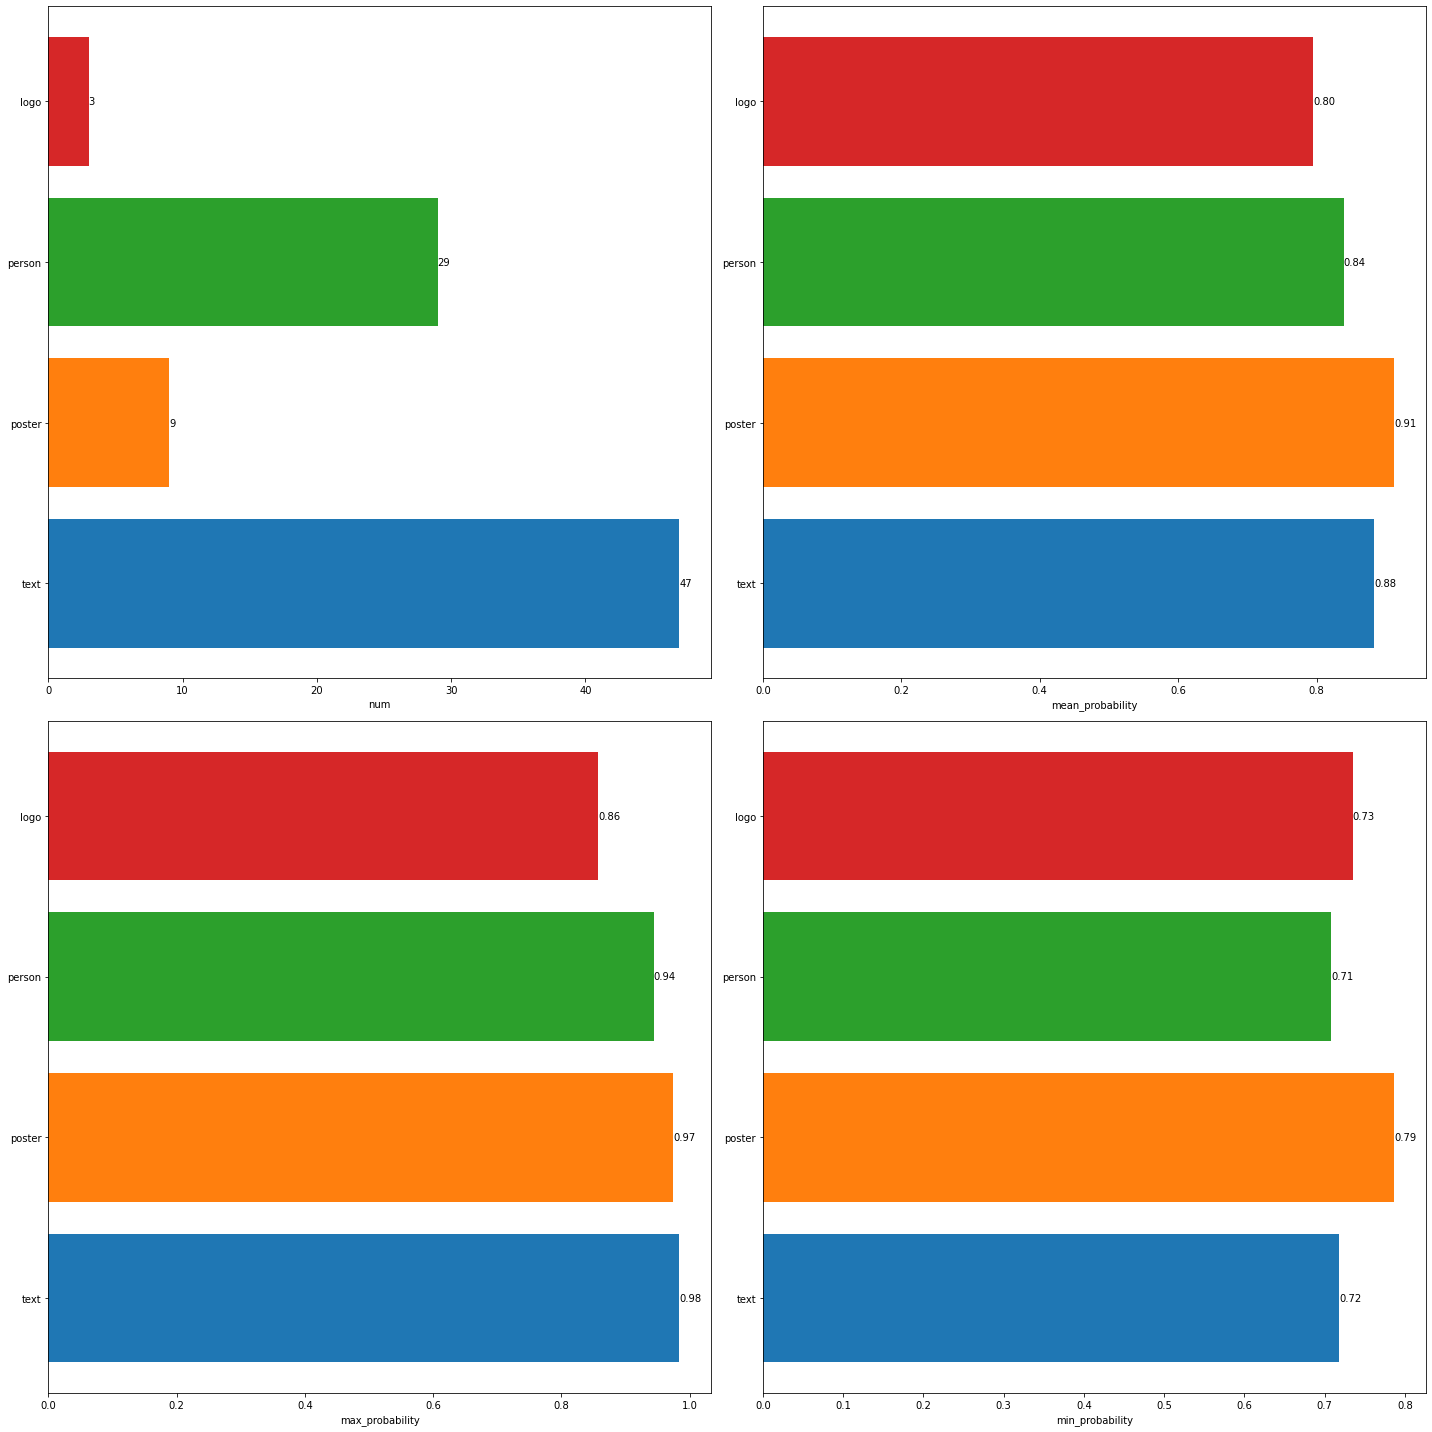

In [18]:
output_dict = {}
output_path = "/".join(path.split("/")[:-3]) + "/detections/{}/{}/".format(path.split("/")[-2], time.strftime("%d,%m,%Y-%H,%M"))
if not isdir(output_path):
    os.makedirs(output_path)

for count, element in enumerate(image_list):
    picture = cv2.imread(path + element)
    predictor = DefaultPredictor(config)
    outputs = predictor(picture)

    predicted_classes = list(np.asarray(outputs["instances"].pred_classes.to("cpu")))
    prediction_scores = list(np.asarray(outputs["instances"].scores.to("cpu")))
    prediction_scores = [float(element) for element in prediction_scores]
    prediction_boxes = outputs["instances"].pred_boxes.to("cpu")
    prediction_boxes = [[int(value) for value in list(np.asarray(element))] for element in prediction_boxes]

    thing_classes = MetadataCatalog.get(config.DATASETS.TRAIN[0]).thing_classes
    predicted_classes_names = [thing_classes[element] for element in predicted_classes]

    output_dict[element] = {"category_names": predicted_classes_names, "prediction_scores": prediction_scores}

    print("[INFO] Predicted {}\t{}/{}".format(element, count+1, len(image_list)))

    v = Visualizer(picture[:,:, ::-1], MetadataCatalog.get(config.DATASETS.TRAIN[0]), scale=1)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    cv2.imwrite(output_path + element[:-4] + "_with_detections.jpg", out.get_image()[:, :, ::-1])

with open(output_path + "detections.json", "w+") as output_file:
    json.dump(output_dict, output_file)


prediction_analysis(output_path)

In [21]:
def serial_Predictor(config, path, save_images = False):
    output_dict = {}
    output_path = "/".join(path.split("/")[:-3]) + "/detections/{}/{}/".format(path.split("/")[-2], time.strftime("%d,%m,%Y-%H,%M"))
    if not isdir(output_path):
        os.makedirs(output_path)

    for count, element in enumerate(image_list):
        picture = cv2.imread(path + element)
        predictor = DefaultPredictor(config)
        outputs = predictor(picture)

        predicted_classes = list(np.asarray(outputs["instances"].pred_classes.to("cpu")))
        prediction_scores =  list(np.asarray(outputs["instances"].scores.to("cpu")))
        prediction_scores = [float(element) for element in prediction_scores]
        #prediction_boxes
        thing_classes = MetadataCatalog.get(config.DATASETS.TRAIN[0]).thing_classes
        predicted_classes_names = [thing_classes[element] for element in predicted_classes]

        output_dict[element] = {"category_names": predicted_classes_names, "prediction_scores": prediction_scores}

        print("[INFO] Predicted {}\t{}/{}".format(element, count+1, len(image_list)))

        if save_images:
            v = Visualizer(picture[:,:, ::-1], MetadataCatalog.get(config.DATASETS.TRAIN[0]), scale=1.2)
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

            cv2.imwrite(output_path + element[:-4] + "_with_detections.jpg", out.get_image()[:, :, ::-1])
    
    with open(output_path + "detections.json", "w+") as output_file:
        json.dump(output_dict, output_file)
    
    
    prediction_analysis(output_path)

[INFO] Predicted test_split/eins1_(125).JPG	1/200
[INFO] Predicted test_split/eins1_(138).JPG	2/200
[INFO] Predicted test_split/eins1_(156).JPG	3/200
[INFO] Predicted test_split/eins1_(178).JPG	4/200
[INFO] Predicted test_split/eins1_(203).JPG	5/200
[INFO] Predicted test_split/eins1_(222).JPG	6/200
[INFO] Predicted test_split/eins1_(244).JPG	7/200
[INFO] Predicted test_split/eins1_(263).JPG	8/200
[INFO] Predicted test_split/eins1_(305).JPG	9/200
[INFO] Predicted test_split/eins1_(336).JPG	10/200
[INFO] Predicted test_split/eins1_(353).JPG	11/200
[INFO] Predicted test_split/zehn1_079.jpg	12/200
[INFO] Predicted test_split/zehn1_150.jpg	13/200
[INFO] Predicted test_split/zehn3_017.jpg	14/200
[INFO] Predicted test_split/zehn3_051.jpg	15/200
[INFO] Predicted test_split/zehn3_082.jpg	16/200
[INFO] Predicted test_split/zehn3_097.jpg	17/200
[INFO] Predicted test_split/zehn3_125.jpg	18/200
[INFO] Predicted test_split/zehn3_154.jpg	19/200
[INFO] Predicted test_split/zehn3_182.jpg	20/200
[INFO] 

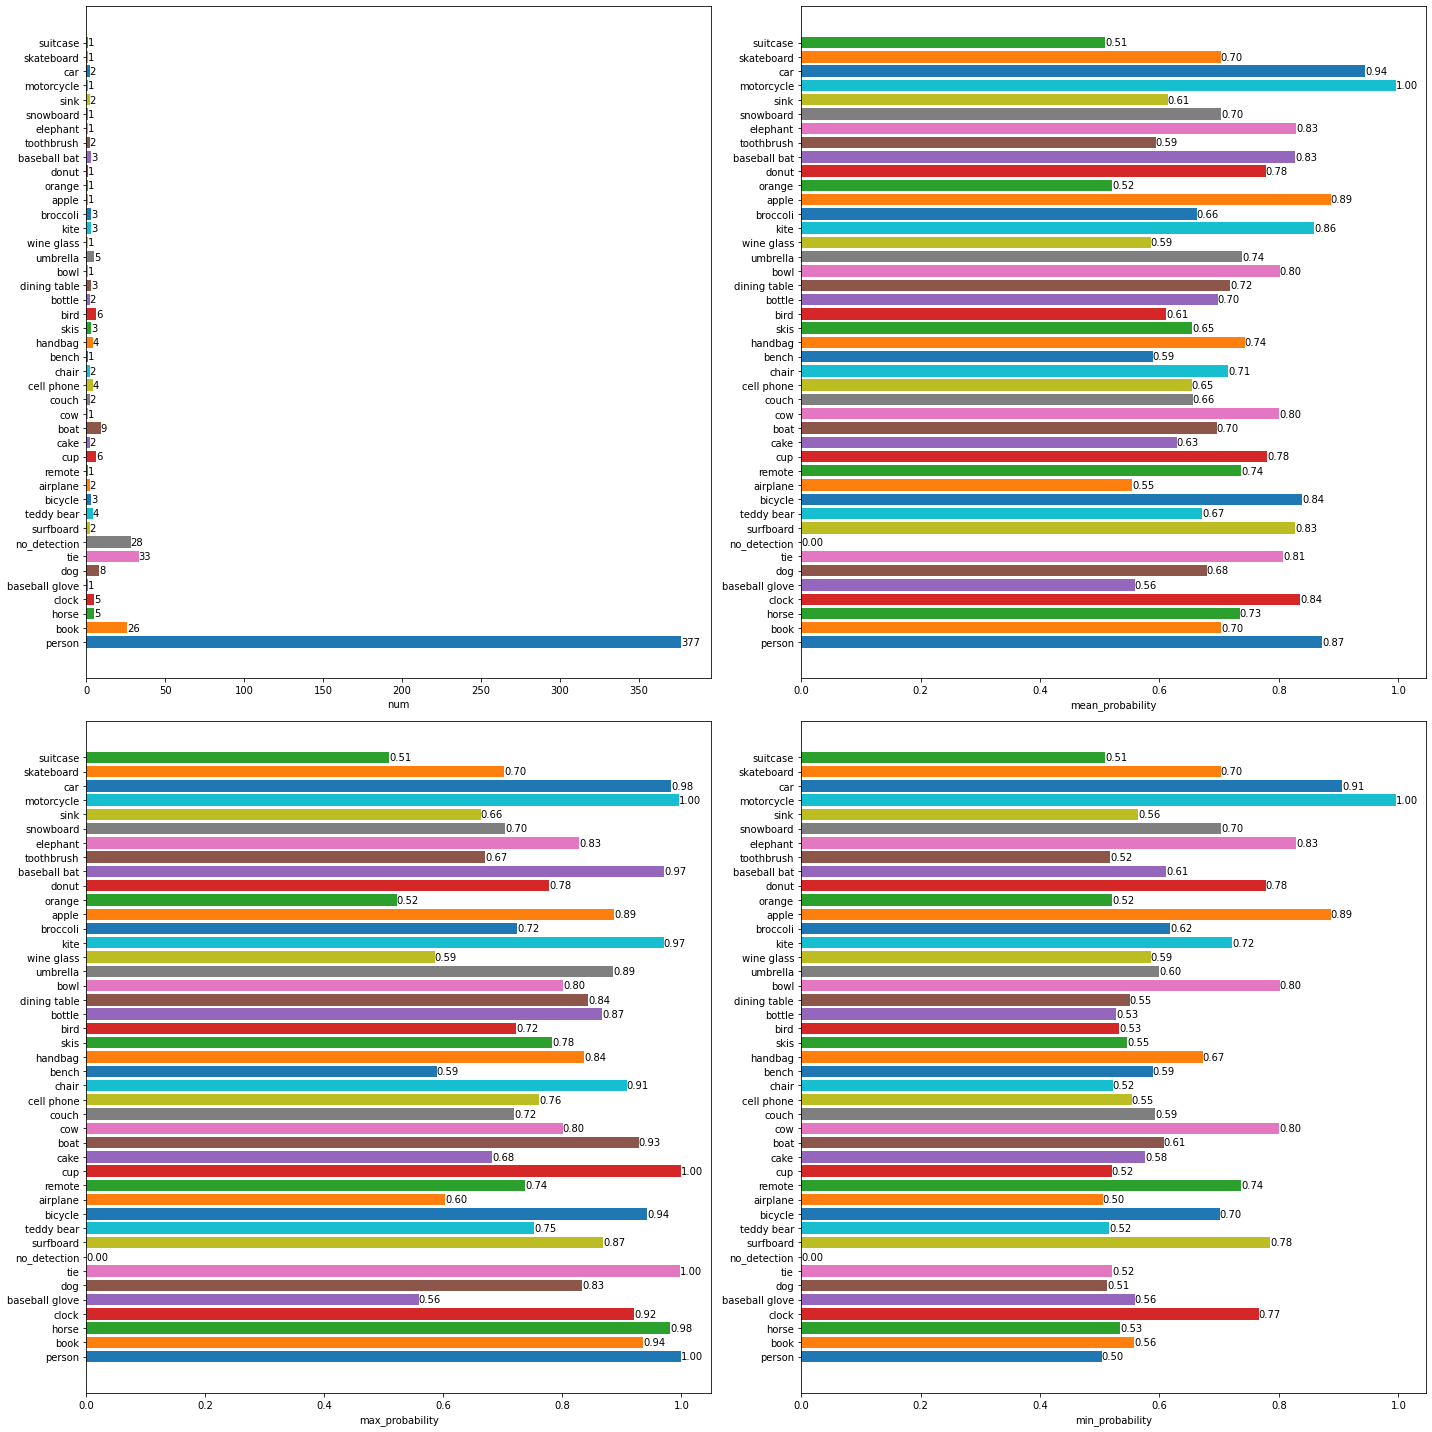

In [22]:
serial_Predictor(config, path)